In [1]:
import rebound
import reboundx
import numpy as np
import pickle
import matplotlib.pyplot as plt
from subprocess import call
%matplotlib inline

def makesim(eps=1.e-4, e=0.01, n=2*np.pi, l=0):
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=1., hash="star") # Sun
    sim.add(m=1.e-5,P=2*np.pi/n,e=e, l=l, hash="planet")
    sim.move_to_com()
    ps = sim.particles
    rebx = reboundx.Extras(sim)
    gh = rebx.add("gravitational_harmonics")
    
    ps["star"].params["J2"] = 2*eps # eps = 1/2*J2*(R/a)**2
    ps["star"].params["R_eq"] = sim.particles[1].a
    return sim, rebx, gh

def runWH(eps=1.e-4, e=0.01, tmax=1e2, n=2*np.pi, dtfac=0.01):   
    simWH, rebxWH, gh = makesim(eps=eps,e=e,n=n)
    times = np.linspace(0, tmax*simWH.particles[1].P, Nout)
    simWH.integrator="whfast"
    simWH.dt = dtfac*simWH.particles[1].P
    psWH = simWH.particles
    hsWH, t = np.zeros(Nout), np.zeros(Nout)
    for i, time in enumerate(times):
        simWH.integrate(time, exact_finish_time=0)
        t[i] = simWH.t
        hsWH[i] = psWH['planet'].e*np.sin(psWH["planet"].pomega)

    sim, rebx, gh= makesim(eps=eps, e=e)
    sim.integrator="ias15"
    ps = sim.particles
    hs = np.zeros(Nout)

    for i, time in enumerate(t):
        sim.integrate(time)
        hs[i] = ps['planet'].e*np.sin(ps["planet"].pomega)

    return t, hs, hsWH

def runother(stepper, eps=1.e-4, e=0.01, tmax=100, n=2*np.pi, dtfac=0.01):   
    Nsteps = int(tmax/dtfac)+1
    cutfactor = max(1, Nsteps/1000) # cull down to 1000 outputs
    sim, rebx, gh = makesim(eps=eps,e=e,n=n)
    ps = sim.particles
    sim.dt = ps[1].P*dtfac
    t, hso, Eerro = [], [], []

    #E0 = sim.calculate_energy() + rebx.gravitational_harmonics_hamiltonian(sim)
    for i in range(Nsteps):
        if i%cutfactor <= 1: # only store 
            hso.append(ps[1].e*np.sin(ps[1].pomega))
            t.append(sim.t)
        #E = sim.calculate_energy() + rebx.gravitational_harmonics_hamiltonian(sim)
        #Eerro[i] = np.abs((E-E0)/E0)
        stepper(sim, rebx, gh)

    sim, rebx, gh = makesim(eps=eps, e=e)
    sim.integrator="ias15"
    ps = sim.particles
    hsIAS = []

    for time in t:
        sim.integrate(time)
        hsIAS.append(ps[1].e*np.sin(ps[1].pomega))
        
    return np.array(t), np.array(hsIAS), np.array(hso)

from reboundx import clibreboundx
from ctypes import byref, c_int

def force(sim, gh):
    ps = sim.particles
    G = sim.G
    for i in range(sim.N):
        ps[i].ax = 0.
        ps[i].ay = 0.
        
    for i in range(sim.N):
        for j in range(i+1, sim.N):
            dx = ps[i].x-ps[j].x
            dy = ps[i].y-ps[j].y
            r2 = dx**2 + dy**2
            r = np.sqrt(r2)
            prefac = G/r2/r
            ps[i].ax -= prefac*ps[j].m*dx
            ps[i].ay -= prefac*ps[j].m*dy
            ps[j].ax += prefac*ps[i].m*dx
            ps[j].ay += prefac*ps[i].m*dy
    clibreboundx.rebx_gravitational_harmonics(byref(sim), byref(gh), sim._particles, c_int(sim.N))
    
def LFstep(sim, rebx, gh):
    ps = sim.particles
    for i in range(sim.N):
        ps[i].x += ps[i].vx*sim.dt/2.
        ps[i].y += ps[i].vy*sim.dt/2.
    force(sim, gh)
    for i in range(sim.N):
        ps[i].vx += ps[i].ax*sim.dt
        ps[i].vy += ps[i].ay*sim.dt
    for i in range(sim.N):
        ps[i].x += ps[i].vx*sim.dt/2.
        ps[i].y += ps[i].vy*sim.dt/2.
        
    sim.t += sim.dt
    
def RK2step(sim, rebx, gh):
    sim.save('temp.bin')
    rebx.save('temp.rebx')
    tempsim = rebound.Simulation.from_file('temp.bin')
    temprebx = reboundx.Extras.from_file(tempsim, 'temp.rebx')
    tempgh = temprebx.get_effect('gravitational_harmonics')
    
    tempsim2 = rebound.Simulation.from_file('temp.bin')
    temprebx2 = reboundx.Extras.from_file(tempsim2, 'temp.rebx')
    tempgh2 = temprebx2.get_effect('gravitational_harmonics')
    
    force(tempsim, tempgh)
    
    tps = tempsim.particles
    a21 = 2.*sim.dt/3.
    tps2 = tempsim2.particles
    ps = sim.particles
    for i in range(sim.N):
        tps2[i].x = ps[i].x + a21*tps[i].vx
        tps2[i].y = ps[i].y + a21*tps[i].vy
        tps2[i].vx = ps[i].vx + a21*tps[i].ax
        tps2[i].vy = ps[i].vy + a21*tps[i].ay
    
    force(tempsim2, tempgh2)
    
    b1 = sim.dt/4.
    b2 = 3*sim.dt/4.
    
    for i in range(sim.N):
        ps[i].x += b1*tps[i].vx + b2*tps2[i].vx
        ps[i].y += b1*tps[i].vy + b2*tps2[i].vy
        ps[i].vx += b1*tps[i].ax + b2*tps2[i].ax
        ps[i].vy += b1*tps[i].ay + b2*tps2[i].ay
    
    sim.t += sim.dt

In [ ]:
%%time
call('rm periprec.pkl', shell=True)
try:
    e, eps, n, dtfac, tshort, tmed, tlong, ksshort, ksmed, kslong, ksWHshort, ksWHmed, ksWHlong = pickle.load(open('periprec.pkl', 'rb'))
except:
    n=2*np.pi
    dtfac = 0.1 # dt/P
    e=0.01
    eps=1.e-4
    ts, tm, tl = 1, 50, 0.1*eps**-1
    Nout = 3141

    tshort, hsshort, hsWHshort = runWH(eps, e, ts, n, dtfac)
    tmed, hsmed, hsWHmed = runWH(eps, e, tm, n, dtfac)
    tlong, hslong, hsWHlong = runWH(eps, e, tl, n, dtfac)
    dtfac = 1.e-2
    tLF, hsIASLF, hsLF = runother(LFstep, eps, e, ts, n, dtfac)
    tLFL, hsIASLFL, hsLFL = runother(LFstep, eps, e, tl, n, dtfac)
    dtfac = 5.e-3
    tRK2, hsIASRK2, hsRK2 = runother(RK2step, eps, e, ts, n, dtfac)
    tRK2L, hsIASRK2L, hsRK2L = runother(RK2step, eps, e, tl, n, dtfac)
    #pickle.dump((e, eps, n, dtfac, tshort, tmed, tlong, hsshort, hsmed, hslong, hsWHshort, hsWHmed, hsWHlong, tLFL, hsIASLFL, hsLFL, tRK2L, hsIASRK2L, hsRK2L), open('periprec.pkl', 'wb'))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

try:
    plt.style.use('paper')
except:
    print("style not found")
     
fig, axarr = plt.subplots(ncols=2, figsize=(15,4))
plt.rcParams["text.usetex"] =True

axarr[0].plot(tshort, hsshort-hsWHshort, '.', markersize=20, label='WH')
axarr[0].plot(tLF, hsLF-hsIASLF, '.', label='LF')
axarr[0].plot(tRK2, hsRK2-hsIASRK2, '.', label='RK2')

axarr[0].plot(tshort, [0]*len(tshort), '--')
axarr[0].set_xlabel('Time (orbits)')
axarr[0].set_ylabel(r'$\Delta h$')
axarr[0].set_title(r'Pericenter Error Over 1 Orbit')
axarr[0].legend()
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))


from scipy.optimize import curve_fit
def f(x, A, B):
    return A*x + B
AWH,BWH = curve_fit(f, tlong, hslong-hsWHlong)[0]
ALF,BLF = curve_fit(f, tLFL, hsLFL-hsIASLFL)[0]
ARK2,BRK2 = curve_fit(f, tRK2L, hsRK2L-hsIASRK2L)[0]
times = np.logspace(0, np.log10(tlong[-1]), 1000)

axarr[1].plot(tRK2L, hsRK2L-hsIASRK2L)
#axarr[1].plot(times, AWH*times, label='WH')
#axarr[1].plot(times, ALF*times, label='LF')
#axarr[1].plot(times, ARK2*times, label='RK2')
#axarr[1].set_xscale('log')
#axarr[1].set_yscale('log')
axarr[1].set_xlabel('Time (orbits)')
axarr[1].set_ylabel(r'$\Delta h$')
axarr[1].set_title('Orbit-Averaged Pericenter Error')
axarr[1].legend()

In [24]:
hsRK2L

array([ 0.        , -0.0876429 , -0.04313982, ...,  0.14962509,
        0.14962509,  0.14962509])

In [50]:
ksLF-ksIASLF

array([ 0.00000000e+00, -3.23320425e-08, -6.46627591e-08, ...,
       -5.74245391e-07, -6.06578011e-07, -6.38910112e-07])

In [51]:
ksRK2-ksIASRK2

array([ 0.00000000e+00, -1.63127696e-08, -3.26252686e-08, ...,
       -5.96470654e-07, -6.12783662e-07, -6.29096382e-07])

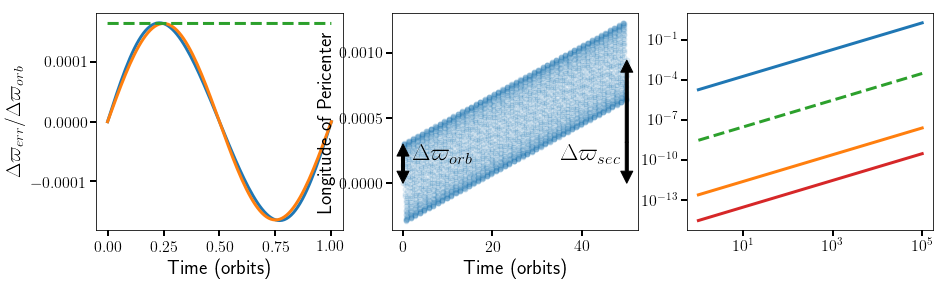

In [130]:
import matplotlib.pyplot as plt
%matplotlib inline

try:
    plt.style.use('paper')
except:
    print("style not found")
     
fig, axarr = plt.subplots(ncols=3, figsize=(15,4))
plt.rcParams["text.usetex"] =True
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

dpo_orb = 3*eps/e
dpo_sec = 3*eps*n*tmed[-1]
tfac = np.pi**2/6.*dtfac**2

pred = tfac*np.sin(n*tshort)
axarr[0].plot(tshort, (pomegasWHshort-pomegasshort)/dpo_orb)
axarr[0].plot(tshort, pred)
axarr[0].plot(tshort, [tfac]*len(tshort), '--')
axarr[0].set_xlabel('Time (orbits)')
axarr[0].set_ylabel(r'$\Delta \varpi_{err} / \Delta \varpi_{orb}$')

axarr[1].plot(tmed, pomegasmed, '.', alpha=0.1)
axarr[1].annotate(text='', xy=(0, dpo_orb), xytext=(0, dpo_orb/3), arrowprops=dict(width=3, facecolor='black'))
axarr[1].annotate(text='', xy=(0, 0), xytext=(0, dpo_orb/3), arrowprops=dict(width=3, facecolor='black'))
tm = tmed[-1]
axarr[1].text(tm/25, dpo_orb/2, r'$\Delta \varpi_{orb}$', fontsize=24)
axarr[1].annotate(text='', xy=(tm, dpo_sec), xytext=(tm, dpo_sec/3), arrowprops=dict(width=3, facecolor='black'))
axarr[1].annotate(text='', xy=(tm, 0), xytext=(tm, dpo_sec/3), arrowprops=dict(width=3, facecolor='black'))
axarr[1].text(0.7*tm, dpo_orb/2, r'$\Delta \varpi_{sec}$', fontsize=24)
axarr[1].set_xlabel('Time (orbits)')
axarr[1].set_ylabel('Longitude of Pericenter')

from scipy.optimize import curve_fit
def f(x, A, B):
    return A*x + B
A,B = curve_fit(f, tlong, pomegaslong)[0]
Adiff,Bdiff = curve_fit(f, tlong, pomegaslong-pomegasWHlong)[0]
times = np.logspace(0, np.log10(tlong[-1]), 1000)

#axarr[2].plot(tlong, pomegaslong-pomegasWHlong)
axarr[2].plot(times, A*times)
axarr[2].plot(times, Adiff*times)
axarr[2].plot(times, A*tfac*times, '--')
axarr[2].plot(times, A*eps*tfac*times)
axarr[2].set_xscale('log')
axarr[2].set_yscale('log')

In [691]:
sim, rebx, gh = makesim(eps=1.e3,e=e,n=n, l=0.3)
print(ps[1].vx)
RK2step(sim, rebx, gh)

-5.495560415214833


In [165]:
def run(l, dt):
    sim, rebx, gh = makesim(eps=1.e-16,e=0.01,n=2*np.pi, l=l)
    sim.dt = dt*sim.particles[1].P
    E0 = sim.calculate_energy()
    RK2step(sim, rebx, gh)
    E = sim.calculate_energy()
    return np.abs((E-E0)/E0)

In [157]:
def runx(l, dt):
    sim, rebx, gh = makesim(eps=1.e-16,e=0.01,n=2*np.pi, l=l)
    sim.dt = dt*sim.particles[1].P
    RK2step(sim, rebx, gh)
    xRK = sim.particles[1].x
    
    sim, rebx, gh = makesim(eps=1.e-16,e=0.01,n=2*np.pi, l=l)
    sim.integrate(dt*sim.particles[1].P)
    x = sim.particles[1].x
    return np.abs((x-xRK)/x)

In [168]:
dts = np.logspace(-5, -1, 100)
err = np.zeros(100)
for i, dt in enumerate(dts):
    err[i] = run(0.6, dt=dt)

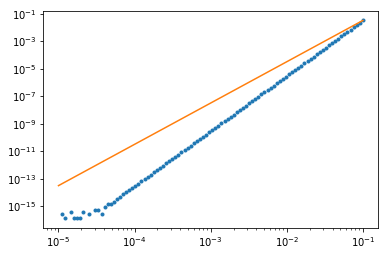

In [169]:
fig, ax = plt.subplots()
ax.plot(dts, err, '.')
ax.plot(dts, err[-1]*(dts/dts[-1])**3)
ax.set_yscale('log')
ax.set_xscale('log')

In [15]:
run(0.3)

2.870419423600823e-10

In [16]:
Nout = 1000
ls = np.linspace(0, 2*np.pi, Nout)
errs = np.zeros(Nout)
for i, l in enumerate(ls):
    errs[i] = run(l)

2.595471062191488e-10


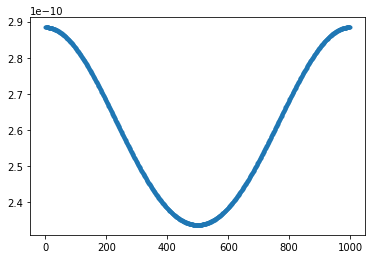

In [17]:
print(np.median(errs))
fig, ax = plt.subplots()
ax.plot(range(Nout), errs, '.')
#ax.set_yscale('log')

In [140]:
%%time
Nout = 30
sim, rebx, gh = makesim(eps=1.e-16,e=0.0,n=2*np.pi, l=1.2)
x0 = sim.particles[1].x
y0 = sim.particles[1].y
sim.dt = sim.particles[1].P/100
E0 = sim.calculate_energy()
Eerr, x, y, ts = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
t=0
for i in range(Nout):
    RK2step(sim, rebx, gh)
    E = sim.calculate_energy()
    Eerr[i] = np.abs((E-E0)/E0)
    x[i] = sim.particles[1].x
    y[i] = sim.particles[1].y
    t += sim.dt
    ts[i] = t

CPU times: user 13.3 ms, sys: 8.15 ms, total: 21.4 ms
Wall time: 31.5 ms


In [135]:
sim, rebx, gh = makesim(eps=1.e-16,e=0.0,n=2*np.pi, l=1.2)
Nout = 1000
es = np.zeros(Nout)
times = np.linspace(0, 1, Nout)
for i, time in enumerate(times):
    sim.integrate(time)
    es[i] = sim.particles[1].e

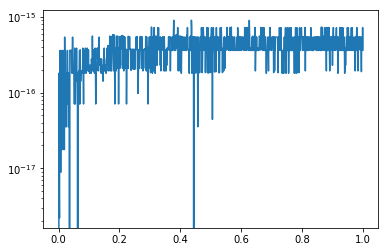

In [125]:
fig, ax = plt.subplots()
ax.plot(times, es)
ax.set_yscale('log')

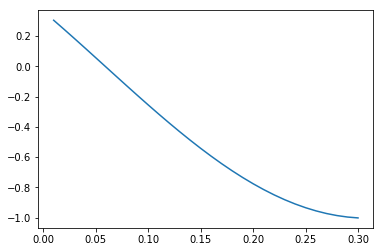

In [139]:
fig, ax = plt.subplots()
ax.plot(ts, x)
xstrue = x0*np.cos(ts) + vs[0]*np.sin(ts)
    
#ax.plot(np.cos(times), np.sin(times))

In [46]:
def pr(sim):
    ps = sim.particles
    print(ps[1].x, ps[1].vx, ps[1].ax, ps[1].y, ps[1].vy, ps[1].ay)
sim, rebx, gh = makesim(eps=eps,e=e,n=n)
RK2step(sim, gh)

NameError: name 'eps' is not defined

In [503]:
%%time
Nout = 10000
sim = rebound.Simulation()
sim.add(m=1)
sim.add(m=1.e-3, a=1.)
sim.add(m=1.e-3, a=1.8)
sim.move_to_com()
sim.dt = sim.particles[1].P/1000
E0 = sim.calculate_energy()
Eerr = np.zeros(Nout)
for i in range(Nout):
    RK2step(sim)
    E = sim.calculate_energy()
    Eerr[i] = np.abs((E-E0)/E0)

CPU times: user 3.51 s, sys: 719 ms, total: 4.23 s
Wall time: 4.25 s


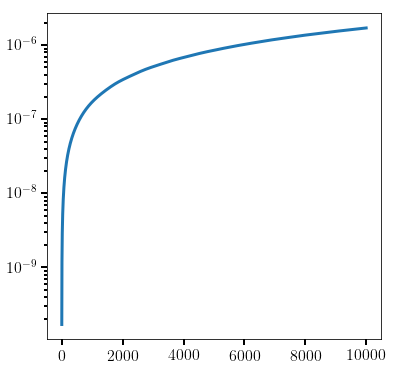

In [504]:
fig, ax = plt.subplots()
ax.plot(range(Nout), Eerr)
ax.set_yscale('log')

In [81]:
def f(x, v):
    return v, -x

def step(x, v, dt, alpha=2./3.):
    k1v, k1a = f(x, v)
    #print('k1', k1)
    a21 = alpha*dt
    k2v, k2a = f(x + a21*k1v, v + a21*k1a)
    #print('k2', k2)
    b1 = (1.-0.5/alpha)*dt
    b2 = 0.5/alpha*dt
    return x + b1*k1v + b2*k2v, v + b1*k1a + b2*k2a

In [102]:
def run(dt, alpha=2./3.):
    Nout = 2
    ts, xs, vs = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
    xs[0] = 0.7
    vs[0] = 0.1
    ts[0] = 0
    for i in range(1, Nout):
        xs[i], vs[i] = step(xs[i-1], vs[i-1], dt, alpha)
        ts[i] = ts[i-1] + dt

    xstrue = xs[0]*np.cos(ts) + vs[0]*np.sin(ts)
    vstrue = -xs[0]*np.sin(ts) + vs[0]*np.cos(ts)
    err = np.abs((xs-xstrue)/xstrue)
    return err[-1]

In [98]:
xs, vs, err = run(0.01)

TypeError: cannot unpack non-iterable numpy.float64 object

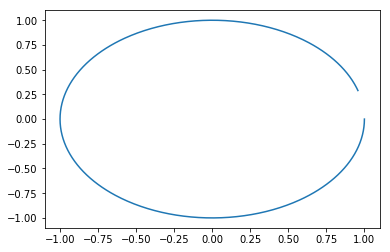

In [99]:
fig, ax = plt.subplots()
ax.plot(xs, vs)

In [103]:
dts = np.logspace(-5, -1, 100)
err = np.zeros(100)
for i, dt in enumerate(dts):
    err[i] = run(dt=dt, alpha=0.8)

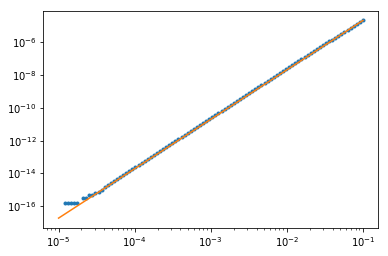

In [105]:
fig, ax = plt.subplots()
ax.plot(dts, err, '.')
ax.plot(dts, err[-1]*(dts/dts[-1])**3)
ax.set_yscale('log')
ax.set_xscale('log')

In [492]:
y = test(1., 0.025)
y

k1 2.5574077246549023
k2 2.7138981399969127


1.0668693884040352

In [490]:
1 + 0.025*0.25*2.557407725 + 0.75*0.025*2.7138981184

1.06686938800125

In [491]:
1 + 0.025*0.25*2.557407725 + 0.75*0.025*2.7138981399969127

1.0668693884061922

In [493]:
y = test(y, 0.025)
y

k1 2.8135246952282467
k2 3.0335073845672524


1.1413321812098478

In [537]:
sim, rebx, gh = makesim(eps=eps,e=e,n=n)
sim.dt = 0.0001*sim.particles[1].P
E0 = sim.calculate_energy()
RK2step(sim, gh)
E = sim.calculate_energy()
np.abs((E-E0)/E0)

8.352242187597194e-06

In [183]:
%%time
n=2*np.pi
dtfac = 1.e-4 # dt/P
e=0.01
eps=1.e-4

Nout = int(1/dtfac)+1
sim, rebx, gh = makesim(eps=eps,e=e,n=n)
ps = sim.particles
sim.dt = ps[1].P*dtfac
tLF, hsLF, EerrLF = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)

E0 = sim.calculate_energy() + rebx.gravitational_harmonics_hamiltonian(sim)
for i in range(Nout):
    hsLF[i] = ps[1].e*np.sin(ps[1].pomega)
    tLF[i] = sim.t
    E = sim.calculate_energy() + rebx.gravitational_harmonics_hamiltonian(sim)
    EerrLF[i] = np.abs((E-E0)/E0)
    LFstep(sim, gh)
    
sim, rebx, gh = makesim(eps=eps, e=e)
sim.integrator="ias15"
ps = sim.particles
hsIAS = np.zeros(Nout)

for i, time in enumerate(t):
    sim.integrate(time)
    pomegasIAS[i] = ps["planet"].pomega
    hsIAS[i] = ps[1].e*np.sin(ps[1].pomega)

CPU times: user 1.38 s, sys: 7.72 ms, total: 1.39 s
Wall time: 1.39 s


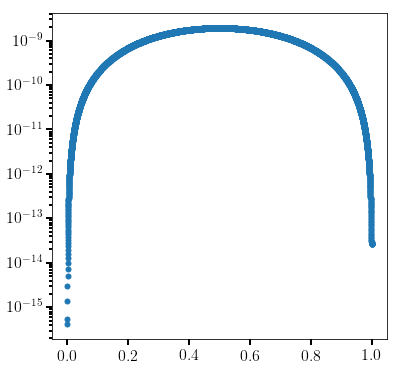

In [184]:
fig, ax = plt.subplots()
ax.plot(tLF, EerrLF, '.')
ax.set_yscale('log')
#ax.plot(t, pomegasIAS)

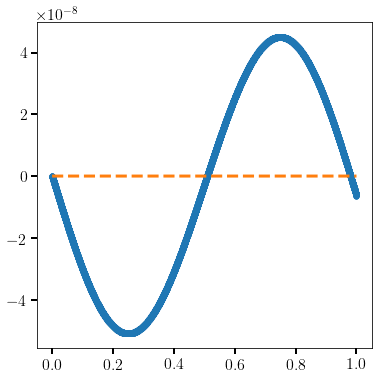

In [185]:
fig, ax = plt.subplots()
ax.plot(tLF, hsLF-hsIAS, '.')
ax.plot(tLF, [0]*len(tLF), '--')
#ax.plot(t, pomegasIAS)

In [479]:
%%time
n=2*np.pi
dtfac = 1.e-4 # dt/P
e=0.01
eps=1.e-16

Nout = 1#int(1/dtfac)+1
sim, rebx, gh = makesim(eps=eps,e=e,n=n)
ps = sim.particles
sim.dt = ps[1].P*dtfac
x, y = np.zeros(Nout), np.zeros(Nout)
pomegas, t, hs = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
Eerr = np.zeros(Nout)

E0 = sim.calculate_energy() + rebx.gravitational_harmonics_hamiltonian(sim)
for i in range(Nout):
    ps = sim.particles
    x[i] = ps[1].x
    y[i] = ps[1].y
    pomegas[i] = ps[1].pomega
    hs[i] = ps[1].e*np.sin(ps[1].pomega)
    t[i] = sim.t
    RK2step(sim, gh)
    E = sim.calculate_energy() + rebx.gravitational_harmonics_hamiltonian(sim)
    Eerr[i] = np.abs((E-E0)/E0)

sim, rebx, gh = makesim(eps=eps, e=e)
sim.integrator="ias15"
ps = sim.particles
pomegasIAS, hsIAS = np.zeros(Nout), np.zeros(Nout)

for i, time in enumerate(t):
    sim.integrate(time)
    pomegasIAS[i] = ps["planet"].pomega
    hsIAS[i] = ps[1].e*np.sin(ps[1].pomega)

CPU times: user 3.65 ms, sys: 305 µs, total: 3.96 ms
Wall time: 2.34 ms


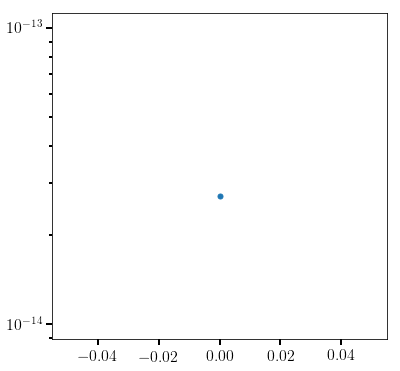

In [480]:
fig, ax = plt.subplots()
ax.plot(t, Eerr, '.')
ax.set_yscale('log')
#ax.plot(t, pomegasIAS)

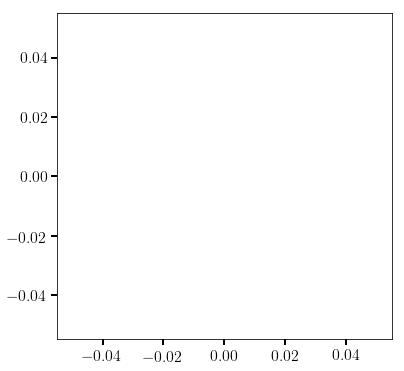

In [473]:
fig, ax = plt.subplots()
ax.plot(t, hs-hsIAS)
ax.plot(t, [0]*len(t), '--')
#ax.plot(t, pomegasIAS)

In [85]:
diff = pomegaslong-pomegasWHlong
Adiffs = []
for i in range(100):
    Adiff,Bdiff = curve_fit(f, tlong[:-(i+1)], diff[:-(i+1)])[0]
    Adiffs.append(Adiff)

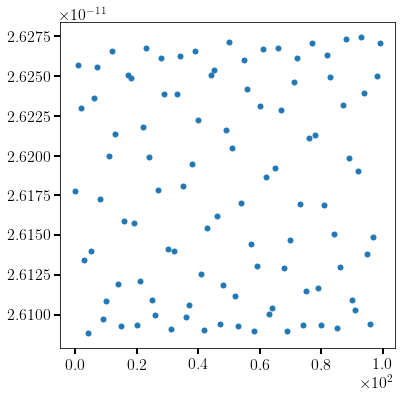

In [89]:
fig, ax = plt.subplots()
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
ax.plot(range(100), Adiffs, '.')
#ax.set_yscale('log')

In [47]:
n=2*np.pi
dtfac = 0.01 # dt/P
e=0.01
epss=np.logspace(-3, -5, 10)
tmax = 0.1*eps**-1

errs = []
for eps in epss:
    t, pomegas, pomegasWH = run(eps, e, tmax, n, dtfac)
    Adiff,Bdiff = curve_fit(f, t, pomegas-pomegasWH)[0]
    errs.append(Adiff*t[-1])

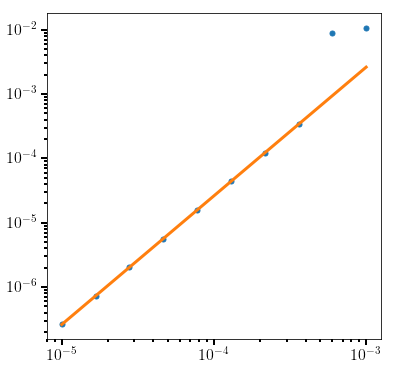

In [55]:
fig, ax = plt.subplots()
ax.plot(epss, np.abs(errs), '.')
ax.plot(epss, np.abs(errs[-1]*(epss/epss[-1])**2))
ax.set_xscale('log')
ax.set_yscale('log')

In [63]:
n=2*np.pi
dtfacs = np.logspace(-3, -1, 10)
e=0.01
eps=1.e-3
tmax = 0.1*eps**-1

errs = []
for dtfac in dtfacs:
    t, pomegas, pomegasWH = run(eps, e, tmax, n, dtfac)
    Adiff,Bdiff = curve_fit(f, t, pomegas-pomegasWH)[0]
    errs.append(Adiff*t[-1])

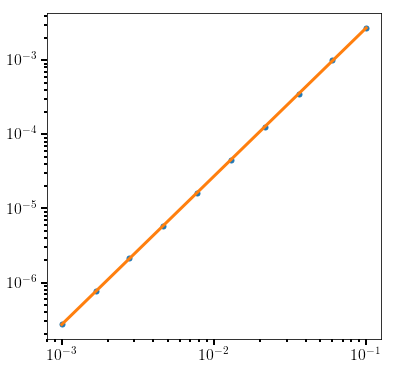

In [64]:
fig, ax = plt.subplots()
ax.plot(dtfacs, np.abs(errs), '.')
ax.plot(dtfacs, np.abs(errs[-1]*(dtfacs/dtfacs[-1])**2))
ax.set_xscale('log')
ax.set_yscale('log')

In [67]:
n=2*np.pi
dtfacs = 0.1
es = np.logspace(-2, -1, 10)
eps=1.e-3
tmax = 0.1*eps**-1

errs = []
for e in es:
    t, pomegas, pomegasWH = run(eps, e, tmax, n, dtfac)
    Adiff,Bdiff = curve_fit(f, t, pomegas-pomegasWH)[0]
    errs.append(Adiff*t[-1])

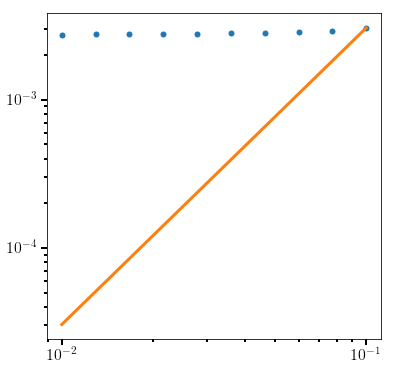

In [72]:
fig, ax = plt.subplots()
ax.plot(es, np.abs(errs), '.')
ax.plot(es, np.abs(errs[-1]*(es/es[-1])**2))
ax.set_xscale('log')
ax.set_yscale('log')

In [50]:
errs[0]*epss/epss[0]

array([-0.01060158, -0.00635548, -0.00381001, -0.00228404, -0.00136925,
       -0.00082084, -0.00049208, -0.000295  , -0.00017685, -0.00010602])

NameError: name 't' is not defined

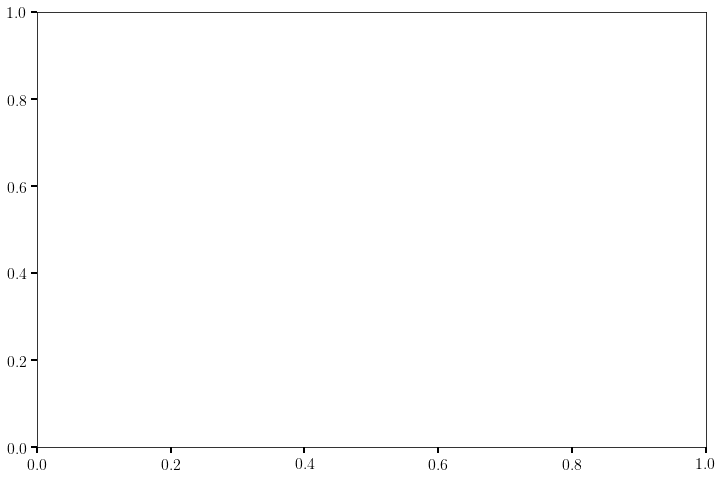

In [38]:
##### %matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,8))

from scipy.optimize import curve_fit
def f(x, A, B):
    return A*x + B
A,B = curve_fit(f, t, pomegas-pomegasWH)[0]
    
ax.plot(t, (pomegas-pomegasWH), '.', alpha=0.1)
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
ax.plot(t, A*t + B, 'b')
ax.plot(t, [0]*len(t), 'b--', alpha=0.3)
pred = 3*eps*(simWH.dt/simWH.particles[1].P)**2/simWH.particles[1].e

#plt.rcParams["text.usetex"] =True
#ax.annotate(text='', xy=(1e5, pred), xytext=(1e5, 0), arrowprops=dict(width=3, facecolor='black'))
#ax.text(8e4, -0.2e-6, r'$\epsilon_{p}(\Delta t/T)^2$', fontsize=24)

In [80]:
np.pi**2/6.*(simWH.dt/ps[1].P)**2*3*eps/ps[1].e*np.sin(ps[1].n*tshort)



4.934817746071188e-07

In [80]:
np.pi**2/6.*(simWH.dt/ps[1].P)**2*3*eps/ps[1].e*np.sin(ps[1].n*tshort)



4.934817746071188e-07

In [79]:
3*eps*(simWH.dt/simWH.particles[1].P)**2/simWH.particles[1].e

3.000009452386392e-07

In [61]:
eps*(simWH.dt/simWH.particles[1].P)**2

5.000000015744817e-10

In [60]:
predslope = eps**2*(simWH.dt/simWH.particles[1].P)**2
predslope*tmax/ps[1].e

2.5000078817538615e-08

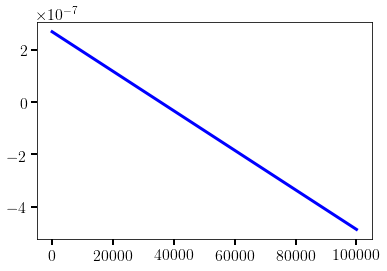

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

AWH,BWH = curve_fit(f, t, pomegasWH)[0]
A,B = curve_fit(f, t, pomegas)[0]

ax.plot(t, A*t + B - (AWH*t + BWH), 'b')
#ax.plot(t, , 'b')

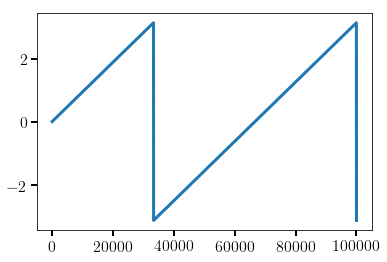

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(t, pomegas)

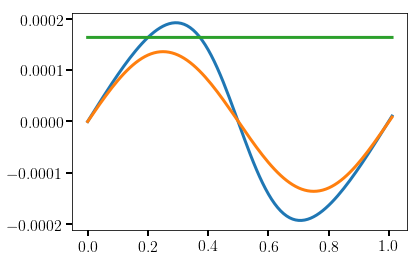

In [144]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
eps = 1/2*ps[0].params['J2']*(ps[0].params['R_eq']/ps[1].a)**2
pred = np.pi**2/6.*(simWH.dt/ps[1].P)**2*3*eps/ps[1].e*np.sin(ps[1].n*tshort)
ax.plot(tshort, (pomegasWHshort-pomegasshort)/np.max(pomegasWHshort))
ax.plot(tshort, pred/np.max(pomegasWHshort))
ax.plot(tshort, [np.pi**2/6.*(simWH.dt/ps[1].P)**2]*len(tshort))

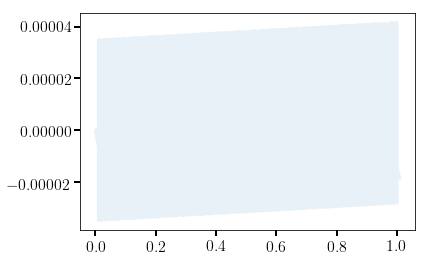

In [116]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
eps = 1/2*ps[0].params['J2']*(ps[0].params['R_eq']/ps[1].a)**2
pred = np.pi**2/6.*(simWH.dt/ps[1].P)**2*3*eps/ps[1].e*np.sin(ps[1].n*tshort)
ax.plot(tshort, (pomegas-pomegasWH), alpha=0.1)
#ax.plot(tshort, pred/np.max(pomegasWHshort))
#ax.plot(tshort, [np.pi**2/6.*(simWH.dt/ps[1].P)**2]*len(tshort))